# Safest Path Rerouting

This project was carried out in collabration with Prof. Richard Sowers and Prof. Daniel Work

### 1. Importing libraries used for execution 

In [2]:
%matplotlib inline
import osmnx as ox
import geopandas as gpd
import networkx as nx
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
ox.config(log_file=True, log_console=True, use_cache=True)

### 2. Importing the Manhattan Island Street Network

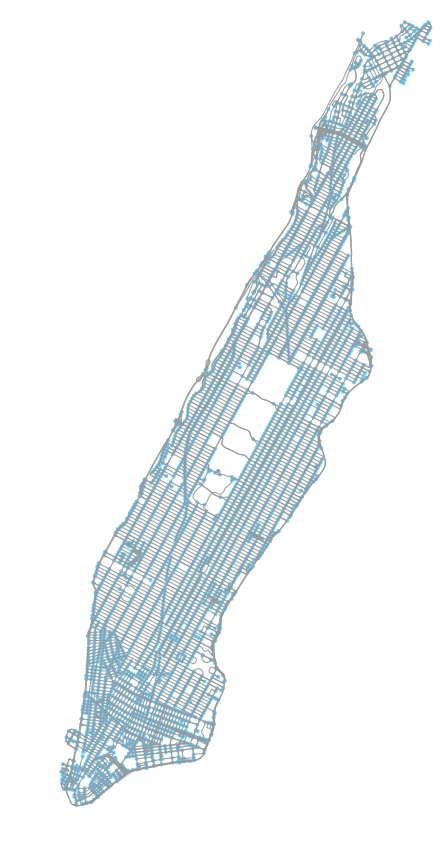

In [3]:
G0 = ox.graph_from_place('Manhattan Island, New York City, New York, USA', network_type='drive')
G0_projected = ox.project_graph(G0)
fig, ax = ox.plot_graph(G0_projected, fig_height = 15)

### 4. Creating Node Collision Frequency Data

Tableau (a Data Visualization tool) was used to identify, clean and extract all the traffic collisions in Manhattan. The original source of this data comes from https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95. The process of further extraction and usage is as coded below:


***Part 1 :*** Extracting data from the CSV file - The csv file **ManLL.csv** used in this code was extracted from the historical data of traffic collisions in NYC using Tableau. A 2D list **latlng** is created which bears a collection of all latitude-longitude pairs of the locations where the collisions occured

***Part 2 :*** Identifying nearest nodes for each instance of traffic collision - **nearestnodes** list contains closest node corresponding to each collision occurence. The more a certain node repeats in this list, the more frequent is the collision occurence near that node.

***Part 3 :*** Calculate the frequency of collisions at these nodes - given that **nearestnodes** has repetitions of nodes (corresponding to frequency of occurence) we simplify the data by creating a new list **node_collisioncount** which bears unique nodes and the frequency of collisions near them. 


**Possible Changes before Deployment**: Although data-cleaning was done using Tableau, a method to automate the complete extraction process might be useful. This implementation might be difficult given that these datasets come with several errors. A combination of OSMNX's area tools and extensive use of geopandas could make this somewhat possible.

In [ ]:
import csv
 
#PART ONE  
latlng = []
for line in open('NYCLL1.csv'): 
    clean_line = line.strip()
    data_points = clean_line.split(',')
    p,q = float(data_points[0]), float(data_points[1])
    pq = [p,q]
    latlng.append(pq) 

#PART TWO   
nearestnodes = [] 
for i in latlng:
    nearestnodes.append(ox.get_nearest_node(G0, i))

#PART THREE    
node_collisioncount = []
unique_nodes = set(nearestnodes)
for i in unique_nodes:
    k = nearestnodes.count(i)
    p = [i,k]
    node_collisioncount.append(p)


### 5. Collision Data Sample + List Simplification


Due to ease of usage, and faster runtime the node_collisioncount shall be split into **node_number** and **node_colcount**. 

**node_number** is a list of all unique nodes in Manhattan

**node_colcount** is a list of all collisions counts with the same indexing as node_number     

In [6]:
node_number = []
node_colcount = []
for i in node_collisioncount:
    node_number.append(i[0])
    node_colcount.append(i[1])
    
print("Sample of node_collisioncount :",node_collisioncount[0:4])
print("Sample of node_number         :",node_number[0:4])
print("Sample of node_colcount       :",node_colcount[0:4])

Sample of node_collisioncount : [[1773060097, 1], [1773060099, 3], [42442755, 2], [561035380, 5]]
Sample of node_number         : [1773060097, 1773060099, 42442755, 561035380]
Sample of node_colcount       : [1, 3, 2, 5]


### 6. Quick Data Visualizations to Understand the Trends of the Collisions per Node

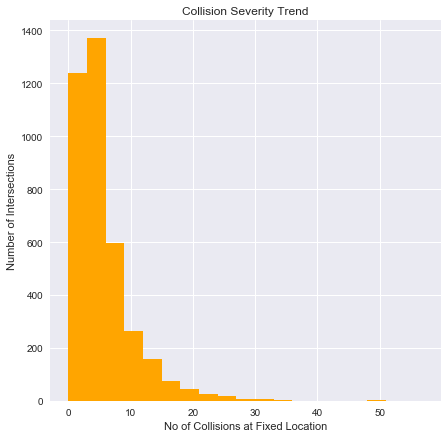

In [7]:
#This graph presents the number of intersections (nodes) corresponding collision count bins
bins = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57]
plt.figure(figsize=(7,7))
plt.hist(node_colcount,bins,color = 'orange')
plt.title("Collision Severity Trend")
plt.xlabel("No of Collisions at Fixed Location")
plt.ylabel("Number of Intersections")

plt.show()

### 7. Path and Distance Calculator for Shortest Path Iterations
**path_and_distance**  takes in origin node, destination node and city map (G) as inputs. The outputs are the route and length of route i.e distance. In OSMNX the route corresponds to the series of nodes that the vehicle will traverse through to reach its destination. 


In [8]:
def path_and_distance(G,origin_node, destination_node):
    route = nx.shortest_path(G, origin_node, destination_node, weight='length')
    length = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
    return route,length


**Possible Changes before Deployment**: Right now the origin node and destination node are the inputs. In reality however the user would input the lat-lng values of origin and destination. A small modification of the code would be needed wherein we would use the ox.get_nearest_node(G, latlng_tuple) function to obtain the origin and destination node given the latlng tuple. This is very easy to implement. In makes sense to use the current version of path_and_distance function since this a proof-of-concept implementation. 

### 8. Distance Calculator for Safest Path Iterations 
The safest path generation algorithm only computes the desired route and not the distance. This is because the resulting distance obtained fromt the skewwed map is heavily modified to  address the safe re-routing path. In order to compute the distance, we need a the **distance_calculator** function that calculates the distance given a route and city map (G). 

In [9]:
def distance_calculator(G,route):
    p = len(route)-1
    dis = 0
    for i in range (0,(p)):    
        length = nx.shortest_path_length(G, route[i] , route[i+1], weight='length')
        dis+= length
    return dis

### 9. Performance Metric: Collisions per Mile
A performance metric informs us if the rerouting has led to a safer route. The **collision_per_mile** function sums up the number of collisions on all nodes on the route and divides it by total distance. Since OSMNX primarily uses meter as a unit for length the following function also does the necessary conversions to miles. Ideally the collision per mile must reduce significantly upon implementation of the safest path algorithm

In [10]:
def collision_per_mile(G,node_collisioncount,route):
    distance = (distance_calculator(G,route)/1609)
    no_collision = 0
    for u,v in node_collisioncount:
        if u in route:
            no_collision+= v
    return (no_collision/distance)

### 10. Additive Penalty Map: Skewwed Map for Safest Path Generation
The function **additive_penalty_map** creates a skewwed map that is an altered version of the original map based on the collision susceptibility of the nodes (intersections) connecting the edges (streets). More the collision susceptibility of a node, more are the connected edges extended in length. The additional length (called **penalty** here) is based on a simple additive rule which follows:-


new length = penalty **+** original length

The penalty is calculated as a product of number of collisions in connecting nodes *times* a factor obtained from by user *times* 20 meters of length

penalty = (no of collisions in connecting nodes) **x** (factor) **x** 20 meters

**One Way Street vs. Two Way Street** - This function also intelligently penalises one way streets and two way streets differently. For one way streets the edge penalty is only based on the entering node of the edge and not the leaving node. In contrast, for a two way street the penalty is a result of both nodes connecting the edge. 


In [11]:
def additive_penalty_map(node_number,node_colcount,factor,G):   
    G1 = G.copy()    
    penalty = []
    for i in node_colcount:
        penalty.append(i*20*factor)
                
    counter = 0
    for j in node_number:
        for u,v,d in G1.edges(data=True):
            if (u==j):
                d['length'] = d['length'] + penalty[counter]
        counter +=1
    return G1        

### 11. Multiplicative Penalty Map: Skewwed Map for Safest Path Generation
The function **multiplicative_penalty_map** creates a skewwed map that is altered based on the collision susceptibility of the nodes (intersections) connecting the edges (streets). More the nodes connecting the edge are prone to accidents, more are the edge are extended in length. This multipled length is based on a simple multiplicative rule which follows:-


new length = (1 **+** penalty) **x** original length

The penalty is calculated as a product of number of collisions in connecting nodes *divided by* a factor inputted by user 

penalty = ((no of collisions in connecting nodes) **/** (factor))

**One Way Street vs. Two Way Street** - This function also intelligently penalises one way streets and two way streets differently. For one way streets the edge penalty is only based on the entering node of the edge and not the leaving node. In contrast, for a two way street the penalty is a result of both nodes connecting the edge. 



In [12]:
def multiplicative_penalty_map(node_number,node_colcount, factor, G):   
    G1 = G.copy()    
    penalty = []
    for i in node_colcount:
        penalty.append(i/factor)     
    counter = 0
    for j in node_number:
        for u,v,d in G1.edges(data=True):
            if (u==j):
                d['length'] = (1+penalty[counter])*d['length']
        counter +=1
    return G1    

### 12. Map Visualization after Map Modification
We create the additive model map and multiplicate model map to visually analysis the change in the lengths. The change in length is demonstrated by the color map used in the figures below. The lengthiest edges which also corresponds to most collision prone are shaded in red. The lesser collision prone edges are shorter length edges and are shaded in green/blue.

In [13]:
#A factor of 5 is used in both cases. 
#NOTE: A factor of 5 doesn't imply comparable results between additive and multiplicative maps
G1 = additive_penalty_map(node_number,node_colcount,5,G0)
G2 = multiplicative_penalty_map(node_number,node_colcount,5,G0)

Normal Map


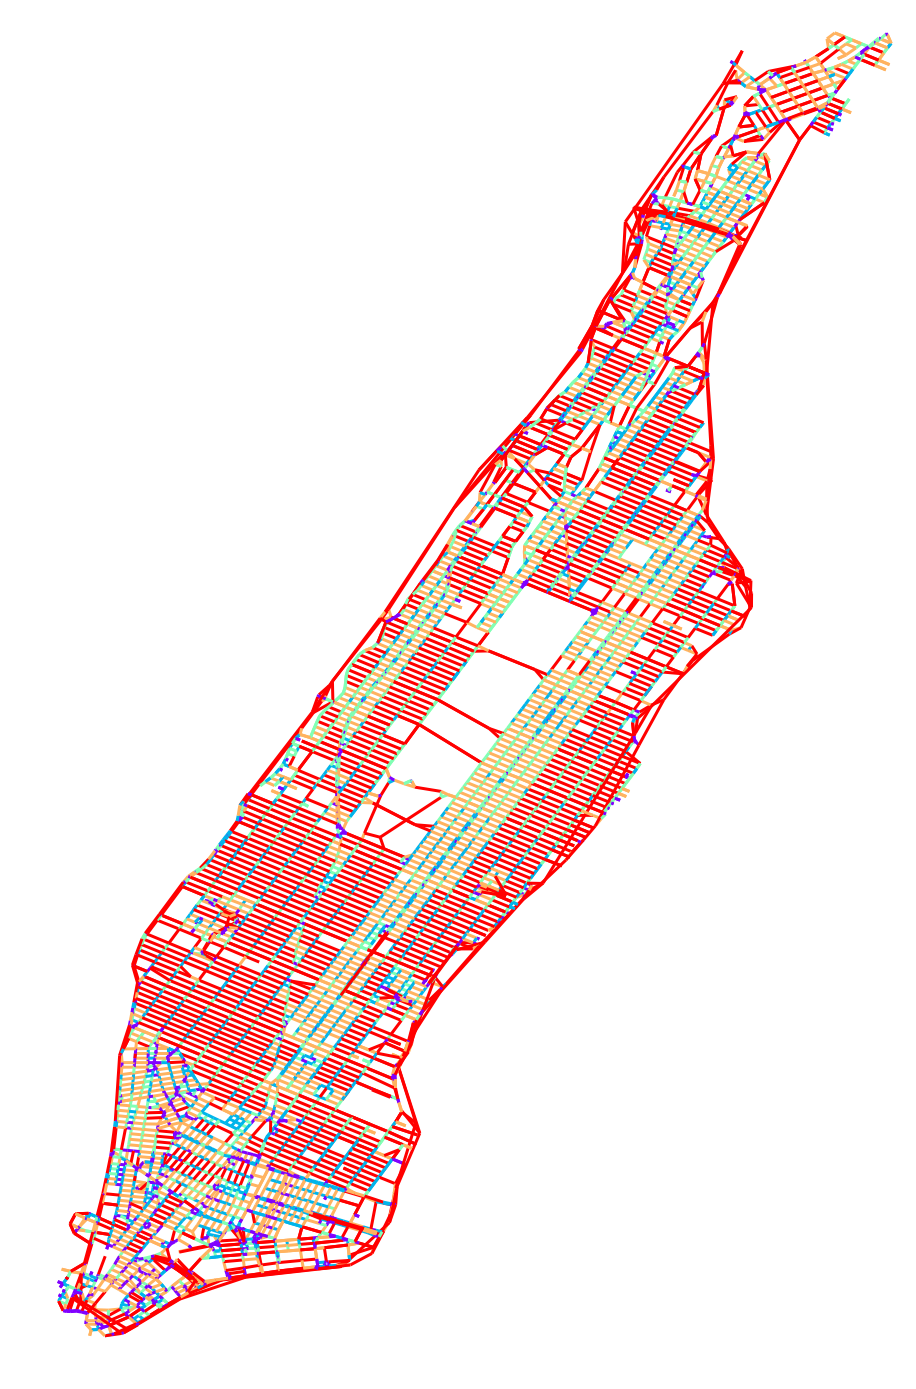

Additive Model |  Skewwed Map


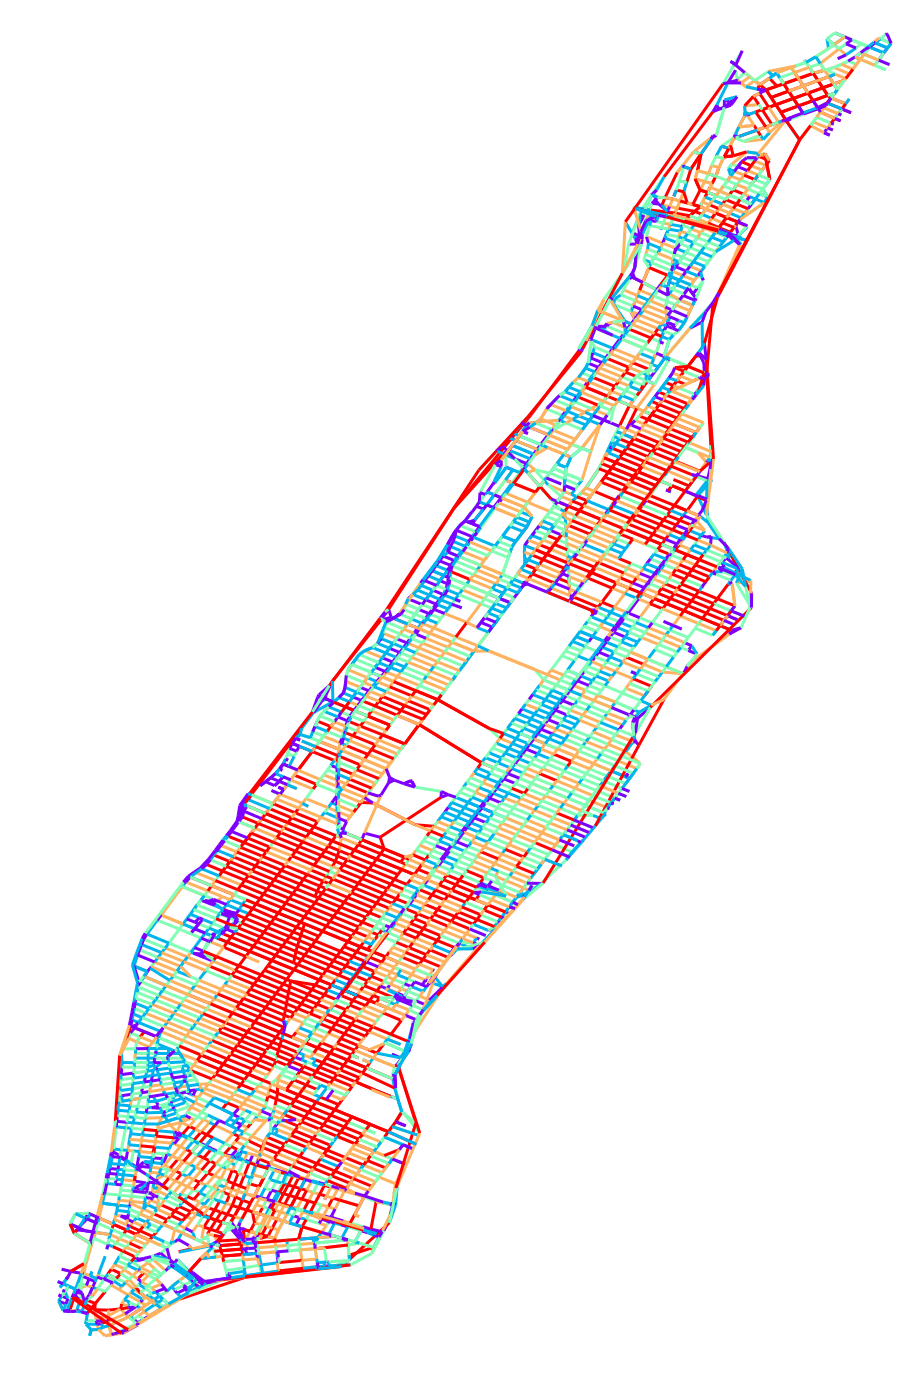

Multiplicative Model | Skewwed Map


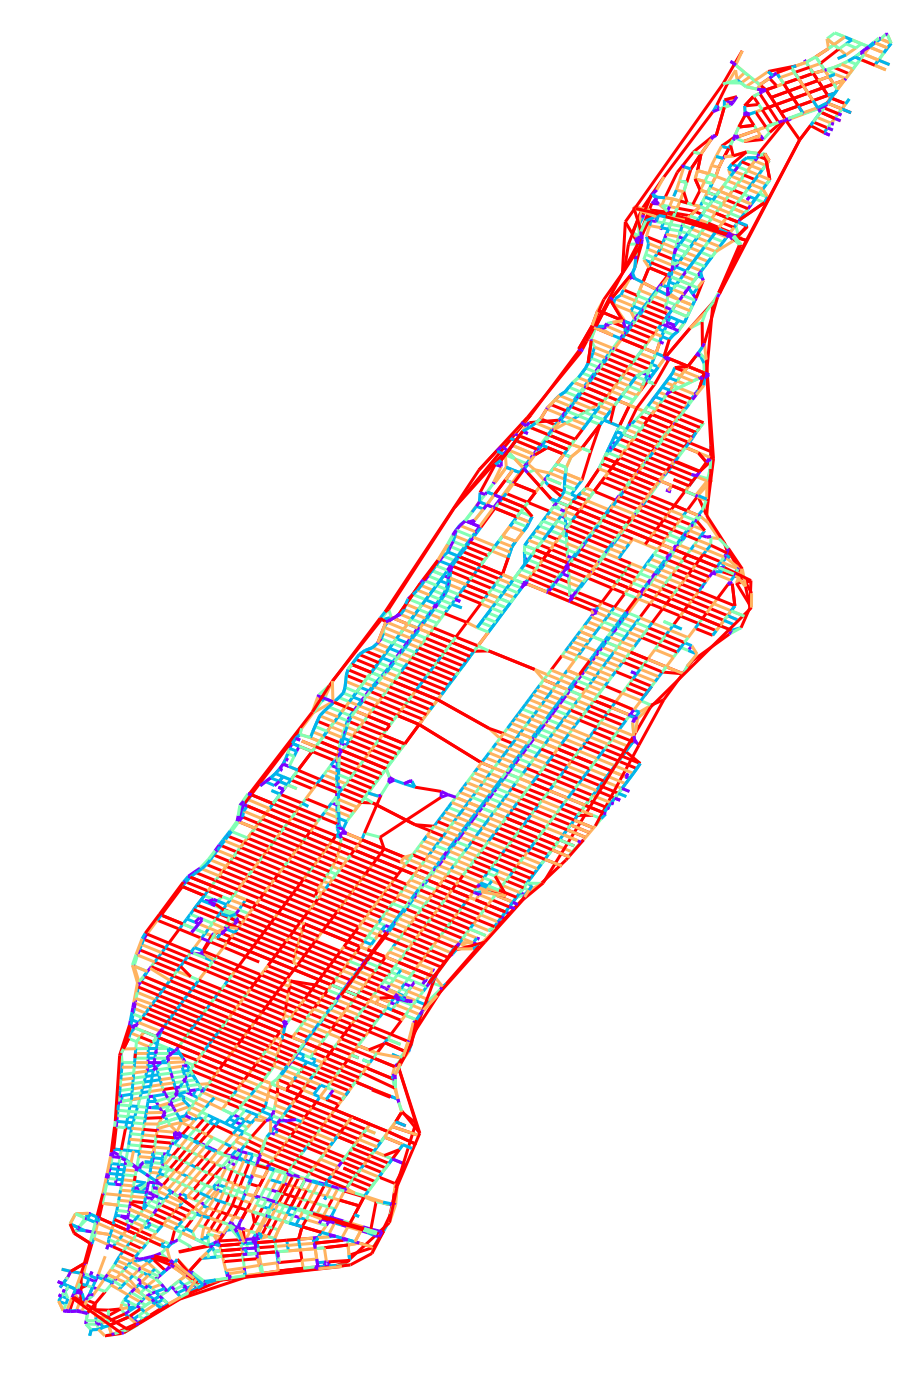

In [61]:
ec0 = ox.get_edge_colors_by_attr(G0, attr='length',num_bins=5,cmap = 'rainbow')
ec1 = ox.get_edge_colors_by_attr(G1, attr='length',num_bins=5,cmap = 'rainbow')
ec2 = ox.get_edge_colors_by_attr(G2, attr='length',num_bins=5,cmap = 'rainbow')

print("Normal Map")

fig, ax = ox.plot_graph(G0, node_color='w', node_edgecolor='k', node_size=0, node_zorder=3, 
                           edge_color=ec0, edge_linewidth=3, edge_alpha=1, use_geom=False,fig_height = 25)

print("Additive Model |  Skewwed Map")
fig, ax = ox.plot_graph(G1, node_color='w', node_edgecolor='k', node_size=0, node_zorder=3, 
                           edge_color=ec1, edge_linewidth=3, edge_alpha=1, use_geom=False,fig_height = 25)

print("Multiplicative Model | Skewwed Map")
fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=0, node_zorder=3, 
                           edge_color=ec2, edge_linewidth=3, edge_alpha=1, use_geom=False,fig_height = 25)



The images below present the maps and the change in their lengths upon using models to skew their lengths based on traffic collision susceptibility. The red edges correspond to longer roads while blue indicates shorter edges. 

![Side by Side Comparison](Maps1.png)

### 13. Origin-Destination Pair Generation
We create random OD pairs to evaluate our model. These OD pairs are generated by randomly choosing nodes from all nodes in the Manhattan area. We ensure that the routes generated from these OD pairs are **atleast 0.5 mile** in length. 

In [15]:
import random
ODpairs = []

One problem in this process is, sometimes when the OD pairs are created, a route joining the origin and destination cannot be created due to inaccessibility of the two nodes given the city's road network. In such a case a KeyError and a NetworkXNoPath is generated. To circumnavigate this problem we create OD pairs in small batches of approximately 100 pairs, till we achieve close to 1000 pairs. We create small batches of OD pairs because the chances of errors popping up is comparitively lesser than creating 1000 pairs at once. 

As described the cell below generates 100 pairs or less. <span style="color:red"> We need to run the cell below 11 times to get more than 1000 pairs that we shall use in our analysis.  </span>  A counter prints the number of OD pairs generated after each run. 
 


<span style="color:red">  **Note**: Sometimes an error would be generated during runtime, this is excepted because of the problem described above. In that case re-run the cell once again till the OD pair counter produces more than 1000 pairs.  </span>

**Possible Changes before Deployment**: Although exception handling techniques could be applied - for example a nested try-except implementation can be done, such attempts have been unsuccessful so far. This issue might not be much of a concern since this is only to test the performance of the algorithm, and becomes irrelevant during actual deployment.

In [29]:
#RUN ME 11 TIMES
for i in range(0,100):
    origin = random.choice(node_number)
    destination = random.choice(node_number)
    dis = nx.shortest_path_length(G0, origin, destination, weight='length')
    if (dis>805):
        k = [origin, destination]
        ODpairs.append(k)
print ("OD pairs Counter: ",len(ODpairs), " pairs")

OD pairs Counter:  1096  pairs


In [30]:
#Using only first 1000 of the OD pairs generated.
ODpairs = ODpairs[:1000]
print ("OD pairs Counter: ",len(ODpairs), " pairs")

OD pairs Counter:  1000  pairs


### 14. Distribution of Lengths of Routes Generated from OD Pairs
It helps to know the distribution of lengths of the routes. **From some of our prilimary efforts we found that safest path algorithm impacts shorter routes and longer routes a little differently.** There could be a need to alter the penalty (i.e extent of penalty) based on the original route length of the OD  pair.  

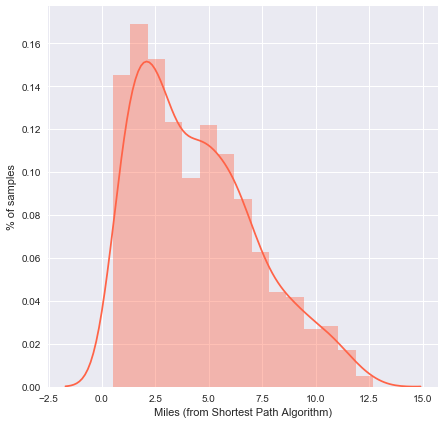

In [31]:
ODpairlengths = []
for i in ODpairs:
    routelength = round((nx.shortest_path_length(G0, i[0], i[1], weight='length'))/1609,2)
    ODpairlengths.append(routelength)

fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
plt.ylabel("% of samples")
plt.xlabel("Miles (from Shortest Path Algorithm)")
sns.distplot(ODpairlengths,color="tomato");

**Possible Changes before Deployment**: The distribution shows an unequal distribution of distance. Although in reality this distribution might be close to actual distribution of trip-lengths within Manhattan, in the later stages of this proof-of-concept it might help to to have an equal distribution within each bin to evaluate the effectiveness of the algorithm for different route-lengths. 

### 15. Distribution of Distance and Collisions Per Mile on Different Models
In the following visualization we assess how the collisions per mile and distance has changed following the safest routing implementation.

In [32]:
dsn = [] #distance
cpm = [] #Collisions per mile
dsn1 = [] #distance -- additive model
cpm1 = [] #Collision per mile -- additive model
dsn2 = [] #distance -- multiplicative model
cpm2 = [] #Collision per mile -- multiplicative model 

for pair in ODpairs:
    r, d = path_and_distance(G0,pair[0], pair[1])
    dsn.append(d/1609)
    cpm.append(collision_per_mile(G0,node_collisioncount,r))

for pair in ODpairs:
    r, d = path_and_distance(G1,pair[0], pair[1])
    dsn1.append(distance_calculator(G0,r)/1609)
    cpm1.append(collision_per_mile(G0,node_collisioncount,r))

for pair in ODpairs:
    r, d = path_and_distance(G2,pair[0], pair[1])
    dsn2.append(distance_calculator(G0,r)/1609)
    cpm2.append(collision_per_mile(G0,node_collisioncount,r))


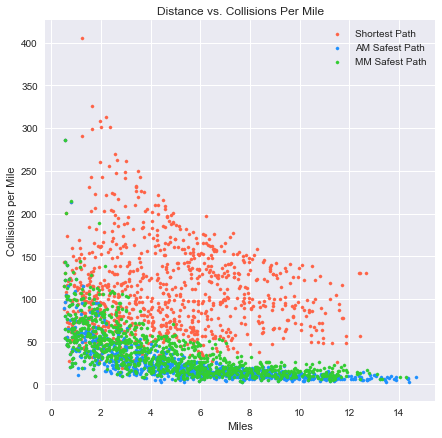

In [33]:
dsn = np.array(dsn)
cpm = np.array(cpm)
dsn1 = np.array(dsn1)
cpm1 = np.array(cpm1)
dsn2 = np.array(dsn2)
cpm2 = np.array(cpm2)
plt.figure(figsize=(7,7))
plt.scatter(dsn,cpm,s=10,c='tomato',label="Shortest Path")
plt.scatter(dsn1,cpm1,s=10,c='dodgerblue',label="AM Safest Path")
plt.scatter(dsn2,cpm2,s=10,c='limegreen',label="MM Safest Path")
plt.ylabel("Collisions per Mile")
plt.xlabel("Miles")
plt.title("Distance vs. Collisions Per Mile")
plt.legend()
plt.show()

The scatterplot above demonstrates the spread of the points with respect the the CPM (Collision Per Mile) and Distance. It is evident that both models are doing really well on longer routes in comparison to shorter route. Also this additive model take the user through a more safe path than the multiplicative model on an average. 

/Users/AnirudhInvictus/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2401: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


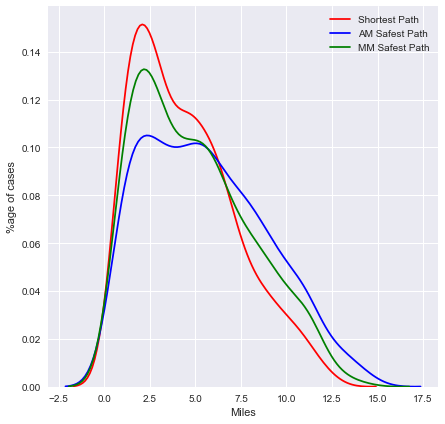

In [34]:
plt.figure(figsize=(7,7))
sns.kdeplot(dsn,label="Shortest Path", c='r')
sns.kdeplot(dsn1,label="AM Safest Path",c='b')
sns.kdeplot(dsn2, label = "MM Safest Path",c='g')
plt.ylabel("%age of cases")
plt.xlabel("Miles");

The line plot above demonstrates the change in distribution of distance of the two models. The blue curve is the original distribution (from the shortest path algorithm). The red and green paths represent the Additive Model (AM) and Multiplicative Model (MM) respectively. From the distribution we understand that the MM does a good job at restricting the additional distance in comparsion to the AM.

/Users/AnirudhInvictus/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2401: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


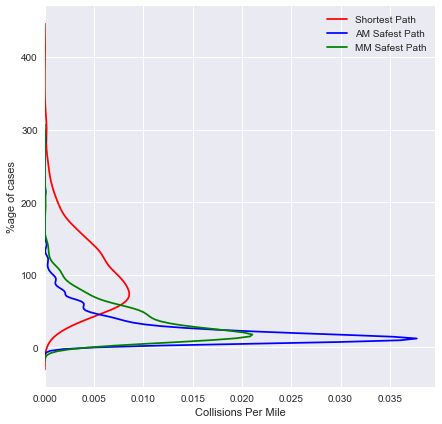

In [35]:
plt.figure(figsize=(7,7))
sns.kdeplot(cpm,label="Shortest Path",vertical=True,c='r')
sns.kdeplot(cpm1,label="AM Safest Path",vertical=True,c='b')
sns.kdeplot(cpm2, label = "MM Safest Path",vertical=True,c='g')
plt.ylabel("%age of cases")
plt.xlabel("Collisions Per Mile");

The line plot above demonstrates the change in distribution of Collisions Per Mile (CPM) of the two models. The blue curve is the original distribution (from the shortest path algorithm). The red and green paths represent the Additive Model (AM) and Multiplicative Model (MM) respectively. From the distribution we understand that the AM does an excellent job in reducing the CPM exponentially. The MM also does a fairly good job. 

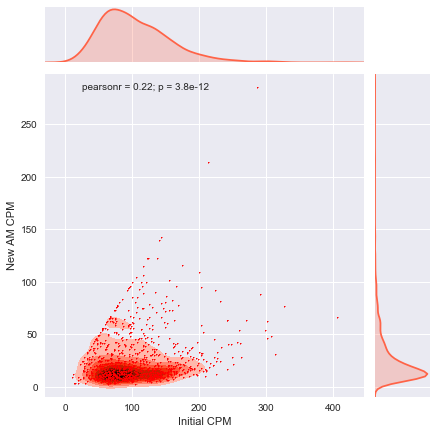

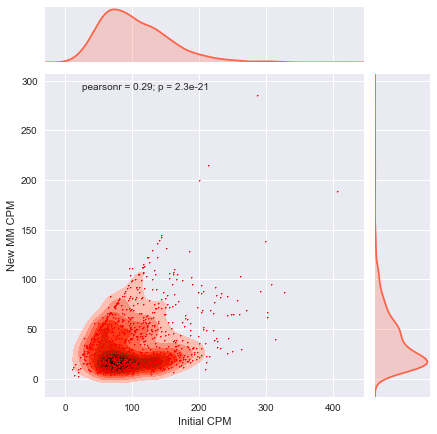

In [36]:
g = sns.jointplot(x=cpm, y=cpm1, kind="kde", color="tomato")
g.plot_joint(plt.scatter, c="r", s=1, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)

g.set_axis_labels("Initial CPM", "New AM CPM");

g = sns.jointplot(x=cpm, y=cpm2, kind="kde", color="tomato")
g.plot_joint(plt.scatter, c="r", s=1, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)

g.set_axis_labels("Initial CPM", "New MM CPM");

The above two Kernel Density plots show that the Additive Model has a superior performance in reducing the CPM, however the trade-off with the distance is the next step in this exploration. 

### 16. Demonstration of the Additive and Multiplicative Model

Normal Shortest Path Below


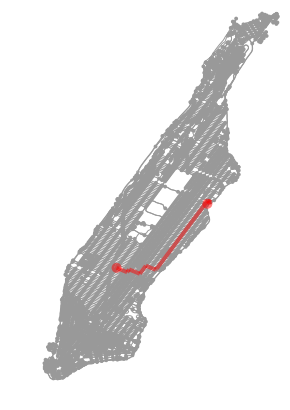

Normal Shortest Path -- Actual Distance:  4.0 miles | Collisions Per Mile:  97.76
Additive Model, Safest Path Below


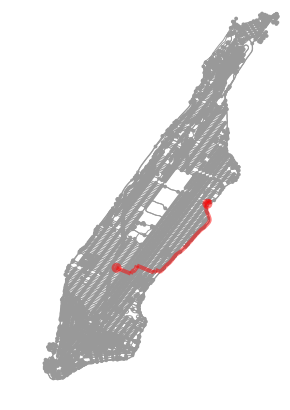

Additive Model -- Actual Distance:  4.33 miles | Collisions Per Mile:  19.18
Multiplicative Model, Safest Path Below


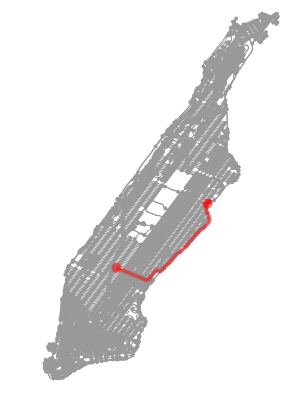

Multiplicative Model -- Actual Distance:  4.3 miles | Collisions Per Mile:  21.42
---------------------------------


In [38]:
example = ODpairs[19:20]
for pair in example:
    
    print ("Normal Shortest Path Below")
    r,d = path_and_distance(G0,pair[0], pair[1])
    fig, ax = ox.plot_graph_route(G0, r,fig_height = 7)
    print("Normal Shortest Path -- Actual Distance: ",round(d/1609,2),"miles | Collisions Per Mile: ", round(collision_per_mile(G0,node_collisioncount,r),2))
    
    print ("Additive Model, Safest Path Below")
    r,d = path_and_distance(G1,pair[0], pair[1])
    fig, ax1 = ox.plot_graph_route(G0, r,fig_height = 7)
    print("Additive Model -- Actual Distance: ",round((distance_calculator(G0,r)/1609),2),"miles | Collisions Per Mile: ", round(collision_per_mile(G0,node_collisioncount,r),2))
    
    print ("Multiplicative Model, Safest Path Below")
    r,d = path_and_distance(G2,pair[0], pair[1])
    fig, ax = ox.plot_graph_route(G0, r,fig_height = 7)
    print("Multiplicative Model -- Actual Distance: ",round((distance_calculator(G0,r)/1609),2),"miles | Collisions Per Mile: ", round(collision_per_mile(G0,node_collisioncount,r),2))
    print("---------------------------------")